<a href="https://colab.research.google.com/github/AlejandroVillazonG/Tareas_INF398/blob/main/T2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>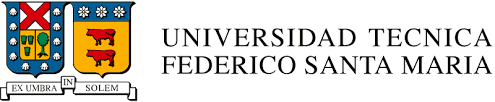</center>



<hr style="height:2px;border:none"/>
<h1 align='center'> INF-398 INTRODUCCIÓN AL APRENDIZAJE AUTOMÁTICO - 2023-1 </h1>

<H3 align='center'> Tarea 2  </H3>
<hr style="height:2px;border:none"/>

**Temas**
* Manipulaciones en pandas y numpy, imputación de datos y preprocesamientos
* Feature Engineering
* Regresión
* Clasificación
* Árboles y Bosques de Regresión
* Máquinas de ensamblado
* Redes Neuronales


Importe las librerías necesarias para cargar explorar el conjunto de datos.

In [166]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, mean_absolute_error, mutual_info_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.tree import DecisionTreeRegressor

import os
from urllib import request
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from keras.models import Model, Sequential
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping

import warnings

# Ignorar las advertencias
warnings.filterwarnings("ignore")

# 1. Predicción de la calidad de vinos

Los árboles de regresión, también conocidos como árboles de decisión para regresión, son un tipo de algoritmo de aprendizaje supervisado que se utiliza para predecir valores numéricos. Son una potente herramienta para tareas de regresión y ofrecen varias ventajas y consideraciones.

<center><img src=https://cdn.shopify.com/s/files/1/1277/3667/files/an-essential-guide-1_480x480.png?v=1674719515></center>


Los conjuntos de datos provienen del UCI Machine Learning Repository. Estos conjuntos de datos están relacionados con las variantes tintas y blancas del vino portugués "Vinho Verde".

Estos dos conjuntos de datos contienen varias propiedades químicas de distintos vinos, como la acidez, el pH, el contenido de alcohol, etc. La variable objetivo es la calidad del vino la cual se puntúa del 0 al 10. Puede considerarse una tarea de clasificación o regresión en la que las clases están ordenadas y no balanceadas. Para esta pregunta nos centraremos en la tarea de regresión.

Variables de entrada (basadas en pruebas físico-químicas):
* fixed acidity
* volatile acidity
* citric acid
* residual sugar
* chlorides
* free sulfur dioxide
* total sulfur dioxide
* density
* pH
* sulphates
* alcohol
* tipo

Variable objetivo (basadas en datos sensoriales):
* quality



Para obtener más información sobre este conjunto de datos, revise el siguiente link: https://www.kaggle.com/datasets/rajyellow46/wine-quality.

## 1.1 Manipulación y exploración del conjunto de datos

Lo primero es obtener los datos, para esto se pueden descargar los archivos directamente de la página de Kaggle a través del link de la descripción de arriba.

Aplique lo aprendido en la tarea 1 y obtenga los datos de la forma que le sea más conveniente siempre y cuando estos sean los del link de la descripción.

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alejandrovillazon","key":"647aa19dc81f77cd4ddbc2b2ee2647e2"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d rajyellow46/wine-quality

100% 98.0k/98.0k [00:00<00:00, 487kB/s]
100% 98.0k/98.0k [00:00<00:00, 486kB/s]


In [5]:
!unzip /content/wine-quality.zip

Archive:  /content/wine-quality.zip
  inflating: winequalityN.csv        


In [6]:
df = pd.read_csv('/content/winequalityN.csv')

### 1.1.1 Exploración del conjunto de datos

Explore el conjunto de datos y responda brevemente las siguientes preguntas:

> a) ¿Cuáles variables poseen valores numéricos y cuáles poseen valores categóricos?

In [7]:
def datainfo(data):
    temp_ps = pd.DataFrame(index=data.columns)
    temp_ps['DataType'] = data.dtypes
    temp_ps["Non-null_Values"] = data.count()
    temp_ps['Unique_Values'] = data.nunique()
    temp_ps['NaN_Values'] = data.isnull().sum()
    temp_ps['NaN_Values_Percentage'] = (temp_ps['NaN_Values']/len(data))*100
    return temp_ps

df_info = datainfo(df)

In [8]:
df_info.DataType

type                     object
fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
Name: DataType, dtype: object

Desde la fuente sin ninguna modificación, tenemos que todas las variables a excepción de _type_ son del tipo numérica, y la variable _type_ es del tipo categórica. Tambien notamos que de las variables del tipo numérica, la única variable que toma valores enteros es _quality_, que podriamos entender como tipo categórica según la información que tenemos del conjunto de datos, pero al menos desde la fuente es numérica.

> b) ¿Existen datos faltantes, si es así en qué atributos faltan datos y cuantos faltan?

Si existen datos faltantes en el conjunto de datos, los atributos que los presentan se muestran a continuación, junto a la cantidad de datos faltantes:

In [9]:
df_info.query('NaN_Values > 0').NaN_Values

fixed acidity       10
volatile acidity     8
citric acid          3
residual sugar       2
chlorides            2
pH                   9
sulphates            4
Name: NaN_Values, dtype: int64

> c) ¿Qué técnicas conoce para rellenar los datos faltantes de los atributos del dataset? (si no conoce ninguna investigue al menos 2)

Conocemos las siguientes técnicas:

* Rellenar los datos faltantes con el promedio o mediana del atributo en cuestión, tenemos como opción antes agrupar los datos según otro atributo (por ejemplo la variable target) y luego aplicar esta técnica.

* Interpolación en los datos faltantes, consiste en aplicar una interpolación en la columna del atributo en cuestión, esta puede ser por ejemplo una interpolación lineal. Se recomienda/usa cuando los datos son temporales, por ejemplo con series económicas se utiliza esta técnica al cambiar la frecuencia de los datos, por ejemplo de trimestral a mensual, se rellenan los datos de los meses intermedios interpolando.

### 1.1.2 Exploración de Features

En problemas de regresión, el desbalance de la variable objetivo se refiere a una distribución desigual de los valores de la variable objetivo en el conjunto de datos. Esto significa que hay una presencia significativa de valores en una clase o rango de valores en comparación con otras clases o rangos de valores. Considerando lo anterior responda las siguientes preguntas:

> a) Grafique histogramas y box plots de cada variable y comente acerca de la distribución de las características y de la variable objetivo



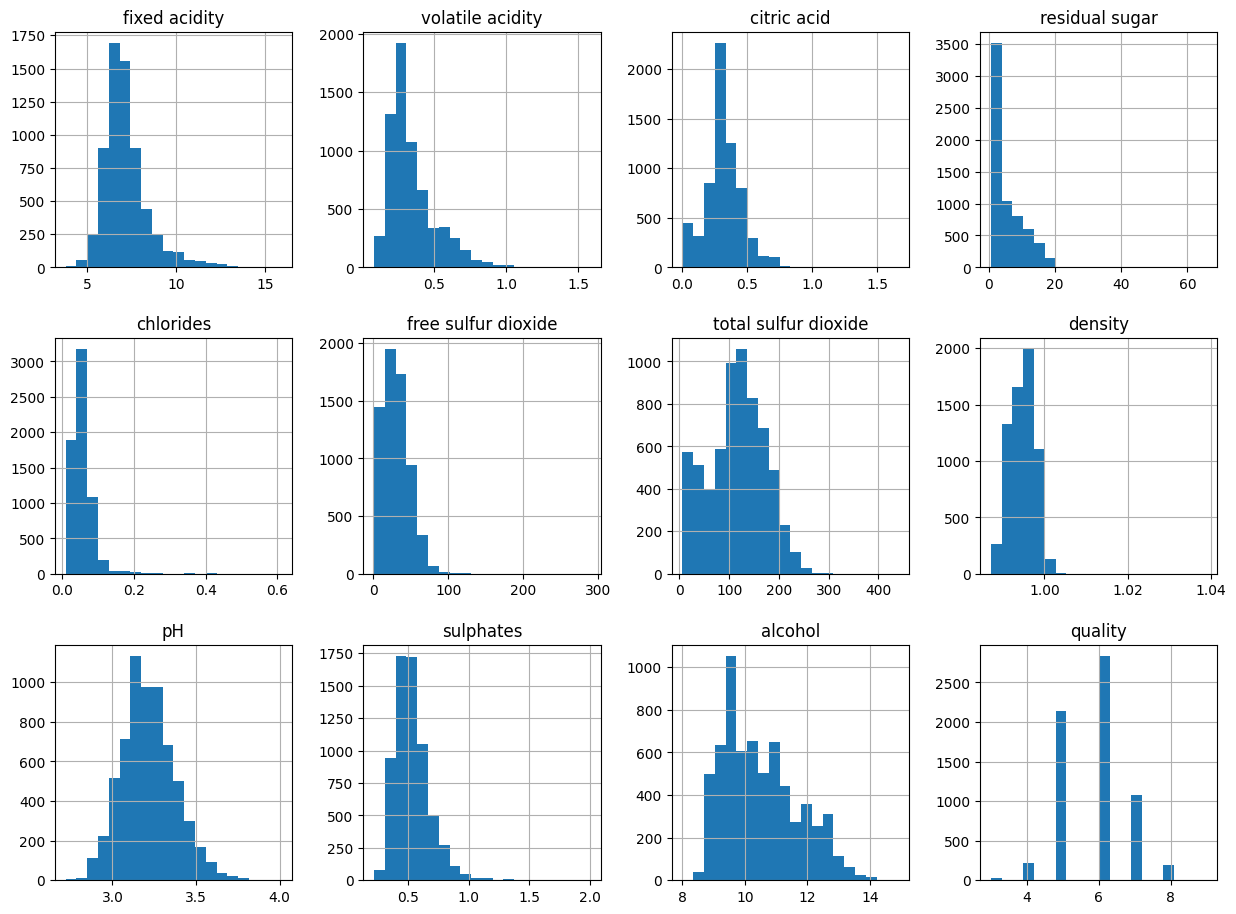

In [10]:
df.hist(figsize=(15,15), layout=(4,4), bins=20);

***COMENTARIOS***

---



---



---



---



---



---



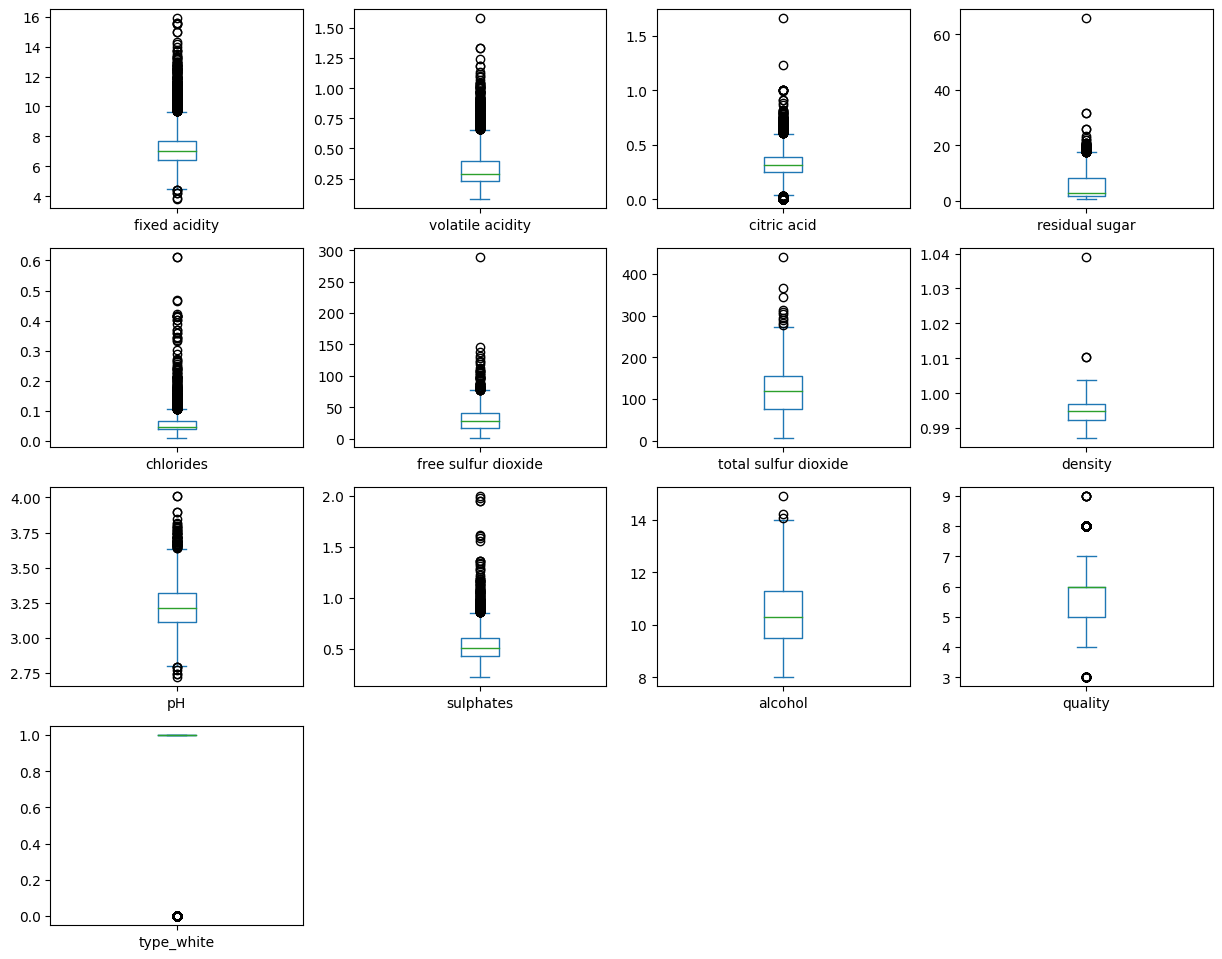

In [52]:
# buscar outliers con boxplots
df.plot(kind="box",subplots=True,layout=(4,4),figsize=(15,15));

***COMENTARIOS***

---
---
---
---
---
---


> b) ¿Considera que están *balanceados* los valores de la variable objetivo?

***RESPUESTA***

---
---
---
---
---
---

> c) ¿Cómo afecta el desbalance en problemas de regresión en términos de la predicción y de la evaluación de un modelo?

En términos de la predicción, cuando existe un desbalance en los valores de la variable objetivo, el modelo puede verse sesgado hacia la mayoría de los valores dominantes. Esto significa que el modelo puede tener dificultades para capturar y predecir con precisión los valores de la clase minoritaria o los valores menos representados en los datos. Como resultado, el modelo puede tener una tendencia a predecir con mayor precisión los valores de la clase mayoritaria, mientras que los valores de la clase minoritaria pueden estar subrepresentados o subestimados.

En términos de la evaluación,


***RESPUESTA***

---
---



Binarizamos la variable _type_:

In [11]:
df = pd.get_dummies(df,drop_first=True)

### 1.1.3 Separación de conjuntos

> a) Separe el conjunto entre variables características y variable objetivo.

In [12]:
X = df.drop(['quality'], axis = 1)
y = df['quality']


> b) Separe el conjunto de datos en un conjunto de entrenamiento y conjunto de prueba, utilizando una proporción 80%-20% respectivamente.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state = 42)

> c) Una vez separado los conjuntos, obtenga la media de cada variable con datos faltantes en el conjunto de **entrenamiento** y reemplace los valores faltantes (NaN) de ambos conjuntos (entrenamiento y prueba) con dicha media.

In [14]:
for column in X_train.columns[X_train.isnull().sum()>0]:
  # Primero rellenamos X_test, pues si primero lo hacemos en X_train
  # cambiará el valor del promedio.
  X_test[column] = X_test[column].fillna(X_train[column].mean())
  X_train[column] = X_train[column].fillna(X_train[column].mean())
  print(f"Se rellenó la variable: {column}")

Se rellenó la variable: fixed acidity
Se rellenó la variable: volatile acidity
Se rellenó la variable: citric acid
Se rellenó la variable: residual sugar
Se rellenó la variable: chlorides
Se rellenó la variable: pH
Se rellenó la variable: sulphates


> d) Estandarice las variables categóricas numéricas no binarias, es decir, todas excepto el tipo de vino y la variable objetivo.

In [15]:
X_scaler = StandardScaler()

X_train[X_train.columns.drop('type_white')] = X_scaler.fit_transform(X_train[X_train.columns.drop('type_white')])

X_test[X_test.columns.drop('type_white')] = X_scaler.transform(X_test[X_test.columns.drop('type_white')])

e) Grafique la relevancia de cada variable con respecto a la variable objetivo utilizando la información mutua entre ambas, en otras palabras: MutualInformation($x_i,y$) siendo $x_i$ la $i$-ésima variable.

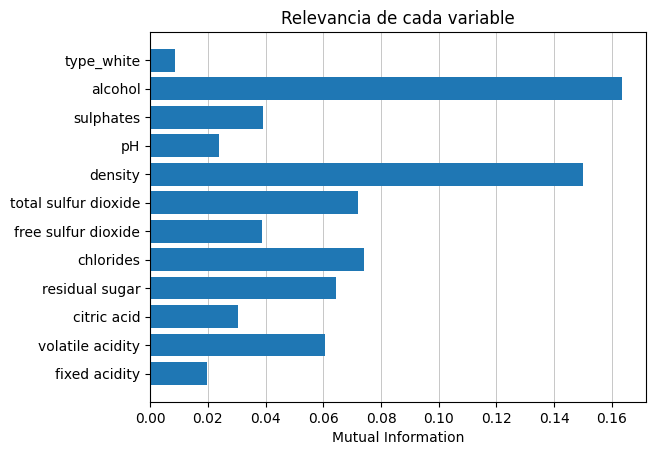

In [17]:
mi = mutual_info_classif(X_train, y_train, random_state = 42)

plt.barh(y = X_train.columns,
         width = mi,
         zorder = 2
        )
plt.xlabel('Mutual Information')
plt.grid(axis = 'x', linewidth=0.5)
plt.title('Relevancia de cada variable')
plt.show()

Del gráfico anterior, notamos que según la información mutua, las variables más relevantes son: _alcohol_ y _density_.

> f) Cree un segundo conjunto quitando las características que menos aportan información según lo observado en su gráfico de la pregunta anterior. El número de características a quitar es algo que usted deberá escoger y argumentar por qué lo escogió. En adelante al conjunto con todas las variables lo llamaremos conjunto $\textit{A}$ y al nuevo conjunto creado con las características quitadas lo llamaremos conjunto $\textit{B}$.

Elegiremos las variables que tienen información mutua mayor o igual al promedio de estas, esto debido a la distribución observada en el gráfico, al elegir el promedio como umbral establecemos un punto medio entre el aporte de las variables, considerando también aquellas que tienen un aporte moderado.

A continuación, se muestran las variables que tienen una información mutua mayor o igual al promedio,

In [18]:
print(*X_train.columns[mi >= mi.mean()], sep = '\n')

residual sugar
chlorides
total sulfur dioxide
density
alcohol


In [19]:
X_train_B = X_train.drop(X_train.columns[mi < mi.mean()], axis = 1)
X_test_B = X_test.drop(X_train.columns[mi < mi.mean()], axis = 1)

## 1.2 Modelos de Regresión


Para las siguientes preguntas usted debera entrenar, validar y evaluar los modelos utilizando los conjuntos $A$ y $B$ por separado, para luego hacer las respectivas comparaciones entre ambos. Cada modelo tiene sus propios hiperparámetros que usted deberá ajustar a través de una búsqueda en grilla, obteniendo así un conjunto de modelos distintos para posteriormente comparar las métricas de evaluación sobre el conjunto de prueba. Usted estará explorando un subconjunto del espacio de hipótesis variando los hiperparámetros que se le indiquen en cada modelo usando el módulo gridsearchcv de la librería sklearn. En el módulo gridsearchcv fije fije los parámetros de la forma:



```
GridSearchCV(estimator, param_grid, scoring=mean_squared_error, refit=True)
```

Siendo estimator el modelo a utilizar, scoring, la métrica para evaluar el modelo y refit=True para una vez probado todo el subconjunto del espacio de hipótesis, escojer el mejor modelo y entrnarlo con todo el conjunto de entrenamiento.

**Nota:** puede utilizar parte del código utilizado en la tarea 1 de esta asignatura.

### 1.2.1 Árbol de regresión


Entrene un árbol de regresión manteniendo fijos por defecto los que no se mencionen y variando los siguientes parámetros utilizando el módulo gridsearchcv de la librería sklearn:

> a) max_depth: Probar con las profundidades 2, 20, 200. Describa brevemente qué es lo que significa modificar este hiperparámetro.

El hiperparámetro _max_depth_ especifica la profundidad máxima permitida en el árbol. Por lo tanto, modificar este hiperparámetro implica cambiar el número máximo de divisiones o niveles que el árbol puede tener desde la raíz hasta las hojas. A mayor _max_depth_, mayor complejidad tendrá el modelo.

> b) max_leaf_nodes: Probar con los valores 10, 50, 100. Describa brevemente qué es lo que significa modificar este hiperparámetro.

El hiperparámetro _max_leaf_nodes_ define el número máximo de nodos hoja permitidos en el árbol. Por lo tanto, modificar este hiperparámetro significa variar el número máximo de nodos terminales que no se dividen más dentro del árbol. A mayor _max_leaf_nodes_, mayor complejidad tendrá el modelo.

Para mejorar el ajuste del modelo de regresión estandarizaremos el target.

In [20]:
y_scaler = StandardScaler()

y_train = y_scaler.fit_transform(np.array(y_train).reshape(-1,1))

In [21]:
tree_model_A = DecisionTreeRegressor()
tree_model_B = DecisionTreeRegressor()

param_grid = {
    'max_depth': [2, 20, 200],
    'max_leaf_nodes': [10, 50, 100]
}

grid_search_A = GridSearchCV(estimator=tree_model_A,
                             param_grid=param_grid,
                             scoring='neg_mean_squared_error',
                             refit=True)

grid_search_B = GridSearchCV(estimator=tree_model_B,
                             param_grid=param_grid,
                             scoring='neg_mean_squared_error',
                             refit=True)
grid_search_A.fit(X_train, y_train)
grid_search_B.fit(X_train_B, y_train);

Responda las siguientes preguntas:

> c) ¿Cuántos modelos de árboles de regresión le quedan en total?

Se obtienen 9 modelos por cada representación A y B, se obtienen 9 pues esa es la cantidad de combinaciones que obtenemos al variar los dos hiperparámetros con 3 valores posibles cada uno, a continuación se presentan las 9 combinaciones mencionadas para ambas representaciones:

In [22]:
print(*grid_search_A.cv_results_['params'], sep='\n')

{'max_depth': 2, 'max_leaf_nodes': 10}
{'max_depth': 2, 'max_leaf_nodes': 50}
{'max_depth': 2, 'max_leaf_nodes': 100}
{'max_depth': 20, 'max_leaf_nodes': 10}
{'max_depth': 20, 'max_leaf_nodes': 50}
{'max_depth': 20, 'max_leaf_nodes': 100}
{'max_depth': 200, 'max_leaf_nodes': 10}
{'max_depth': 200, 'max_leaf_nodes': 50}
{'max_depth': 200, 'max_leaf_nodes': 100}


> d) De todas las combinaciones que entrenó, ¿cual es la que mejores resultados le da? Para esta pregunta evalue el modelo con el conjunto de validación de la grilla utilizando la métrica de evaluación $mean\_squared\_error$.

La mejor combinación de hiperparámetros para cada representación son las que siguen:

In [28]:
print('Para la representación A:',*[f"{key} = {value}" for key, value in grid_search_A.best_params_.items()], sep = "\n\t")
print('\nPara la representación B:',*[f"{key} = {value}" for key, value in grid_search_B.best_params_.items()], sep = "\n\t")

Para la representación A:
	max_depth = 20
	max_leaf_nodes = 50

Para la representación B:
	max_depth = 20
	max_leaf_nodes = 10


In [24]:
y_pred_A = y_scaler.inverse_transform(np.array(grid_search_A.predict(X_test)).reshape(-1,1))
y_pred_B = y_scaler.inverse_transform(np.array(grid_search_B.predict(X_test_B)).reshape(-1,1))

print('MSE para A:', mean_squared_error(y_test, y_pred_A))

print('MSE para B:', mean_squared_error(y_test, y_pred_B))

MSE para A: 0.47483543211390333
MSE para B: 0.5244699420903128


Por lo tanto, basados en la métrica MSE, el mejor modelo es utilizando la representación A, con _max_depth_ = 20 y _max_leaf_nodes_ = 50.

> c) Entrene el conjunto de entrenamiento completo con el mejor modelo y mejor representación ($A$ o $B$) obtenida y evalúe su desempeño sobre el conjunto de prueba utilizando la métrica de evaluación $mean\_squared\_error$.

In [29]:
model1 = DecisionTreeRegressor(max_depth = 20,
                               max_leaf_nodes = 50)
model1.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=20, max_leaf_nodes=50)

In [30]:
mse_model_1 = mean_squared_error(y_test, y_scaler.inverse_transform(np.array(model1.predict(X_test)).reshape(-1,1)))
print(mse_model_1)

0.47483543211390333


### 1.2.2 Random Forest Regressor

Entrene un bosque aleatorio de regresión manteniendo fijos por defecto los que no se mencionen y variando los siguientes parámetros utilizando el módulo gridsearchcv de la librería sklearn:

* max_depth: Probar con las profundidades 2, 20, 200. Describa brevemente qué es lo que significa modificar este hiperparámetro.

El hiperparámetro _max_depth_ controla la profundidad máxima que puede tener un árbol de decisión en el bosque aleatorio.

* max_samples: Probar con las siguientes proporciones 0.1, 0.5, 1.0. Describa brevemente qué es lo que significa modificar este hiperparámetro.

Este hiperparámetro determina la proporción de muestras de entrenamiento que se utilizarán para construir cada árbol individual dentro del bosque aleatorio.

In [43]:
rfg_A = RandomForestRegressor(random_state = 42)
rfg_B = RandomForestRegressor(random_state = 42)

param_grid = {
    'max_depth': [2, 20, 200],
    'max_samples': [0.1, 0.5, 1.0]
}

grid_search_A = GridSearchCV(estimator=rfg_A,
                             param_grid=param_grid,
                             scoring='neg_mean_squared_error',
                             refit=True)
grid_search_B = GridSearchCV(estimator=rfg_B,
                             param_grid=param_grid,
                             scoring='neg_mean_squared_error',
                             refit=True)

grid_search_A.fit(X_train, y_train)
grid_search_B.fit(X_train_B, y_train);


El objetivo de los métodos $\textit{ensemble machine}$ es combinar las predicciones de varios estimadores base construidos con un algoritmo de aprendizaje determinado para mejorar la capacidad de generalización / robustez respecto a un único estimador. Se suelen distinguir dos familias de métodos ensemble: los métodos $averaging$ y los métodos $boosting$. Respecto a lo anterior responda las siguientes preguntas:

> a) Defina con sus propias palabras qué son y en qué se diferencian los métodos $averaging$ y $boosting$.

Son métodos que combinan distintos modelos para mejorar la generalización y robustez del modelo final. Se diferencian en la forma en que se combinan los modelos base, los métodos _averaging_ promedian las predicciones de los estimadores base de forma independiente, mientras que los métodos _boosting_ combinan los estimadores secuencialmente, enfocándose en corregir los errores de los modelos anteriores.

> b) A cual de los dos anteriormente definidos pertenece el modelo de regresión Random Forest?

Pertenece al método _averaging_, pues promedia las predicciones de distintos modelos tipo árbol de decisión para entregar el resultado final.

> c) De todas las combinaciones que entrenó, ¿cual es la que mejores resultados le da? Para esta pregunta evalue el modelo con el conjunto de validación utilizando la métrica de evaluación $mean\_squared\_error$.

A continuación, se presentan las mejores combinaciones de hiperparámetros encontradas para cada representación,

In [44]:
print('Para la representación A:',*[f"{key} = {value}" for key, value in grid_search_A.best_params_.items()], sep = "\n\t")
print('\nPara la representación B:',*[f"{key} = {value}" for key, value in grid_search_B.best_params_.items()], sep = "\n\t")

Para la representación A:
	max_depth = 200
	max_samples = 1.0

Para la representación B:
	max_depth = 200
	max_samples = 1.0


In [45]:
y_pred_A = y_scaler.inverse_transform(np.array(grid_search_A.predict(X_test)).reshape(-1,1))
y_pred_B = y_scaler.inverse_transform(np.array(grid_search_B.predict(X_test_B)).reshape(-1,1))

print('MSE para A:', mean_squared_error(y_test, y_pred_A))

print('MSE para B:', mean_squared_error(y_test, y_pred_B))

MSE para A: 0.31653346153846157
MSE para B: 0.4082065384615385


Por lo tanto, basados en la métrica MSE, el mejor modelo es utilizando la representación A, con _max_depth_ = 200 y _max_samples_ = 1.

In [46]:
model2 = RandomForestRegressor(max_depth = 200, max_samples = 1.0, random_state = 42)
model2.fit(X_train, y_train)
mse_model_2 = mean_squared_error(y_test, y_scaler.inverse_transform(np.array(model2.predict(X_test)).reshape(-1,1)))
print(mse_model_2)

0.31653346153846157


### 1.2.3 Bagging Regressor


Entrene un Bagging regresor utilizando como estimador (parámetro $estimator$) el mejor árbol de decisión obtenido en la pregunta 1.2.1, variando los siguientes parámetros utilizando el módulo gridsearchcv de la librería sklearn:

* n_estimators: Probar con 10, 100, 1000 estimadores. Describa brevemente qué es lo que significa modificar este hiperparámetro.

Modificar este hiperparámetro controla el número de estimadores base que se utilizan en el conjunto.

* max_samples: Probar con las siguientes proporciones 0.1, 0.5, 1.0. Describa brevemente qué es lo que significa modificar este hiperparámetro.

Modificar el hiperparámetro _max_samples_ controla la proporción de muestras utilizadas para entrenar cada estimador base en el conjunto.

In [47]:
bagging_A = BaggingRegressor(estimator=model1)
bagging_B = BaggingRegressor(estimator=model1)

param_grid = {
    'n_estimators': [10, 100, 1000],
    'max_samples': [0.1, 0.5, 1.0]
}

grid_search_A = GridSearchCV(estimator=bagging_A,
                             param_grid=param_grid,
                             scoring='neg_mean_squared_error',
                             refit=True)
grid_search_B = GridSearchCV(estimator=bagging_B,
                             param_grid=param_grid,
                             scoring='neg_mean_squared_error',
                             refit=True)

grid_search_A.fit(X_train, y_train)
grid_search_B.fit(X_train_B, y_train);

Responda las siguientes preguntas

> a) ¿Cómo funciona el modelo Bagging?

El modelo Bagging funciona mediante la creación de múltiples subconjuntos de datos a través de muestreo con reemplazo (bootstrap), donde se entrena un estimador base independiente en cada subconjunto. Luego, las predicciones de los estimadores base se promedian para obtener la predicción final del modelo Bagging.

> b) A qué familia de métodos pertenece el Bagging regresor: $averaging$ o $boosting$.

Pertenece a la familia _averaging_.

> c) De todas las combinaciones que entrenó, ¿cual es la que mejores resultados le da? Para esta pregunta evalue el modelo con el conjunto de validación utilizando la métrica de evaluación $mean\_squared\_error$.

In [48]:
print('Para la representación A:',*[f"{key} = {value}" for key, value in grid_search_A.best_params_.items()], sep = "\n\t")
print('\nPara la representación B:',*[f"{key} = {value}" for key, value in grid_search_B.best_params_.items()], sep = "\n\t")

Para la representación A:
	max_samples = 0.5
	n_estimators = 1000

Para la representación B:
	max_samples = 0.5
	n_estimators = 1000


In [49]:
y_pred_A = y_scaler.inverse_transform(np.array(grid_search_A.predict(X_test)).reshape(-1,1))
y_pred_B = y_scaler.inverse_transform(np.array(grid_search_B.predict(X_test_B)).reshape(-1,1))

print('MSE para A:', mean_squared_error(y_test, y_pred_A))

print('MSE para B:', mean_squared_error(y_test, y_pred_B))

MSE para A: 0.4173123446604953
MSE para B: 0.47412064147297367


In [50]:
model3 = BaggingRegressor(estimator = model1, max_samples = 0.5, n_estimators = 1000)
model3.fit(X_train,y_train)

BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=20,
                                                 max_leaf_nodes=50),
                 max_samples=0.5, n_estimators=1000)

In [51]:
y_pred = y_scaler.inverse_transform(np.array(model3.predict(X_test)).reshape(-1, 1))
mse_model_3 = mean_squared_error(y_test, y_pred)
print(mse_model_3)

0.41729271720345773


## 1.3 Conclusiones

Comente con qué modelo y representación obtiene los mejores resultados, ¿qué otros experimentos realizaría para intentar mejorar los resultados?

***RESPUESTA***

---
---
---
---
---
---


# 2. Reconocimiento de actividad humana mediante sensores de movimiento.

Los conjuntos de datos provienen del UCI Machine Learning Repository. En este conjuntos de datos cada persona realizó seis actividades (CWALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING) llevando un smartphone en la cintura. Utilizando su acelerómetro y giroscopio integrados, capturamos la aceleración lineal de 3 ejes y la velocidad angular de 3 ejes a una frecuencia constante de 50 Hz. El conjunto de datos obtenido se ha dividido aleatoriamente en dos conjuntos, de los que se seleccionó el 70% de los voluntarios para generar los datos de entrenamiento y el 30% los datos de prueba.

<center><img src="https://imgtr.ee/images/2023/06/04/bSx54.jpg" alt="bSx54.jpg" border="0" width="480" height="480" /></center>

Para esta pregunta nos centraremos en la tarea de clasificación de actividades (variable objetivo) según los datos de movimiento proporcionados por los sensores (atributos).

Para cada registro en el conjunto de datos nos centraremos en:
* Aceleración triaxial del acelerómetro (aceleración total) y la aceleración estimada del cuerpo.
* Velocidad angular triaxial del giroscopio.

* Su etiqueta de actividad.

Para obtener el dataset, artículos publicados y más información, por favor dirigirse al siguiente [link](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones).



## 2.1 Obtención, manipulación y exploración del conjunto de datos

Con el link proporcionado arriba, haga click en Data Folders y luego en *UCI HAR Dataset.names* para obtener una guía acerca de la estructura de los directorios. Descargue, descomprima los datos y explore la estructura de los directorios (*UCI HAR Dataset.zip*).

Para esta oportunidad solo nos centraremos en los datos que se encuentran en las carpetas *Inertial Signals*, para entrenamiento y pruebas.

Descargaremos el archivo comprimido directamente de la [página web](https://archive.ics.uci.edu/static/public/240/human+activity+recognition+using+smartphones.zip
):

In [53]:
url = 'https://archive.ics.uci.edu/static/public/240/human+activity+recognition+using+smartphones.zip'
request.urlretrieve(url, 'human+activity+recognition+using+smartphones.zip');

In [54]:
!unzip /content/human+activity+recognition+using+smartphones.zip

Archive:  /content/human+activity+recognition+using+smartphones.zip
 extracting: UCI HAR Dataset.names   
 extracting: UCI HAR Dataset.zip     


In [55]:
os.rename(r"/content/UCI HAR Dataset.zip", r"/content/UCI_HAR_Dataset.zip")
!unzip /content/UCI_HAR_Dataset.zip

Archive:  /content/UCI_HAR_Dataset.zip
   creating: UCI HAR Dataset/
  inflating: UCI HAR Dataset/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/UCI HAR Dataset/
  inflating: __MACOSX/UCI HAR Dataset/._.DS_Store  
  inflating: UCI HAR Dataset/activity_labels.txt  
  inflating: __MACOSX/UCI HAR Dataset/._activity_labels.txt  
  inflating: UCI HAR Dataset/features.txt  
  inflating: __MACOSX/UCI HAR Dataset/._features.txt  
  inflating: UCI HAR Dataset/features_info.txt  
  inflating: __MACOSX/UCI HAR Dataset/._features_info.txt  
  inflating: UCI HAR Dataset/README.txt  
  inflating: __MACOSX/UCI HAR Dataset/._README.txt  
   creating: UCI HAR Dataset/test/
   creating: UCI HAR Dataset/test/Inertial Signals/
  inflating: UCI HAR Dataset/test/Inertial Signals/body_acc_x_test.txt  
   creating: __MACOSX/UCI HAR Dataset/test/
   creating: __MACOSX/UCI HAR Dataset/test/Inertial Signals/
  inflating: __MACOSX/UCI HAR Dataset/test/Inertial Signals/._body_acc_x_test.txt  
  inflating

### 2.1.1 Exploración del conjunto de datos

Una vez comprendida la estructura de los directorios, asegurese de poder navegar por los archivos correctamente:

> a) El código a continuación debe imprimir las rutas a todos los archivos del conjunto de datos que usted acaba de descargar. Ejemplo: /su ruta/UCI HAR Dataset/train/Inertial Signals/body_acc_z_train.txt

In [56]:
for dirname, _, filenames in os.walk('/content/UCI HAR Dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/UCI HAR Dataset/features_info.txt
/content/UCI HAR Dataset/features.txt
/content/UCI HAR Dataset/activity_labels.txt
/content/UCI HAR Dataset/.DS_Store
/content/UCI HAR Dataset/README.txt
/content/UCI HAR Dataset/train/subject_train.txt
/content/UCI HAR Dataset/train/y_train.txt
/content/UCI HAR Dataset/train/X_train.txt
/content/UCI HAR Dataset/train/Inertial Signals/body_gyro_z_train.txt
/content/UCI HAR Dataset/train/Inertial Signals/total_acc_y_train.txt
/content/UCI HAR Dataset/train/Inertial Signals/body_gyro_x_train.txt
/content/UCI HAR Dataset/train/Inertial Signals/total_acc_z_train.txt
/content/UCI HAR Dataset/train/Inertial Signals/total_acc_x_train.txt
/content/UCI HAR Dataset/train/Inertial Signals/body_acc_x_train.txt
/content/UCI HAR Dataset/train/Inertial Signals/body_acc_y_train.txt
/content/UCI HAR Dataset/train/Inertial Signals/body_acc_z_train.txt
/content/UCI HAR Dataset/train/Inertial Signals/body_gyro_y_train.txt
/content/UCI HAR Dataset/test/X_test.txt


In [57]:
LABELS = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']
SIGNALS = ["body_acc_x_", "body_acc_y_", "body_acc_z_",
           "body_gyro_x_", "body_gyro_y_", "body_gyro_z_",
           "total_acc_x_", "total_acc_y_", "total_acc_z_"]

> b) Obtenga la ruta exacta de los archivos e insertelos en una lista (entrenamiento y prueba ). El código a continuación es solo una sugerencia, usted puede optimizar y modificarlo.

In [58]:
train_paths = [f'/content/UCI HAR Dataset/train/Inertial Signals/{signal}train.txt' for signal in SIGNALS]
test_paths = [f'/content/UCI HAR Dataset/test/Inertial Signals/{signal}test.txt' for signal in SIGNALS]

In [59]:
print(*test_paths, sep = '\n')

/content/UCI HAR Dataset/test/Inertial Signals/body_acc_x_test.txt
/content/UCI HAR Dataset/test/Inertial Signals/body_acc_y_test.txt
/content/UCI HAR Dataset/test/Inertial Signals/body_acc_z_test.txt
/content/UCI HAR Dataset/test/Inertial Signals/body_gyro_x_test.txt
/content/UCI HAR Dataset/test/Inertial Signals/body_gyro_y_test.txt
/content/UCI HAR Dataset/test/Inertial Signals/body_gyro_z_test.txt
/content/UCI HAR Dataset/test/Inertial Signals/total_acc_x_test.txt
/content/UCI HAR Dataset/test/Inertial Signals/total_acc_y_test.txt
/content/UCI HAR Dataset/test/Inertial Signals/total_acc_z_test.txt


> c) Cree una función __load_X que reciba una lista de rutas como alguna de las anteriormente creadas, y retorne un arreglo de numpy con las siguientes dimensiones (n_samples, signal_len, sensor) donde:
* n_samples: es el tamaño de la muestra, o sea, el total de experimentos.
* signal_len: es el largo de la señal de los sensores.
* sensor: es el sensor o el eje del sensor el cual registra la señal, por ejemplo acelerómetro en el eje $y$.

In [60]:
def __load_X(X_signal_paths):
  return np.stack([np.loadtxt(path) for path in X_signal_paths], axis = 2)

In [61]:
x_train = __load_X(train_paths)
x_test = __load_X(test_paths)

> d) Cargue las clases del conjunto de entrenamiento y pruebas en arreglos numpy.

In [62]:
y_train = np.loadtxt('/content/UCI HAR Dataset/train/y_train.txt',  dtype=np.int32)
y_test = np.loadtxt('/content/UCI HAR Dataset/test/y_test.txt', dtype=np.int32)

### 2.1.2 Análisis del conjunto de datos

Responda las siguientes preguntas:

> a) ¿Cuántos experimentos le quedan en el conjunto de entrenamiento y en el de test?

In [63]:
print(f'En el conjunto de entrenamiento quedaron: {x_train.shape[0]} experimentos.')
print(f'Mientras que en el conj. de test quedan: {x_test.shape[0]} experimentos.')

En el conjunto de entrenamiento quedaron: 7352 experimentos.
Mientras que en el conj. de test quedan: 2947 experimentos.


> b) ¿Qué valores obtiene para las dimensiones recién definidas (n_samples, signal_len, sensor)?

Obtenemos los siguientes valores:

In [65]:
print(f'Conjunto de entrenamiento: {x_train.shape}')
print(f'Conjunto de prueba: {x_test.shape}')

Conjunto de entrenamiento: (7352, 128, 9)
Conjunto de prueba: (2947, 128, 9)



> c) Considerando todo lo que usted ha aprendido en este curso y en las tareas anteriores, ¿Qué puede decir de los atributos de este conjunto de datos?. Obtenga estadísticas descriptivas y sintetice brevemente con sus propias palabras lo que observe, apoyándose de gráficos como histográmas, boxplots heatmaps de correlación, etc.

**RESPUESTA**

---
---
---


> d) Si quisiera entrenar una red neuronal feedforward con este conjunto de datos, ¿cómo deben representarse las dimensiones de cada experimento (sample) para que sirvan de entrada para este tipo de red?

Cada experimento debe estar representado como un vector unidimensional.

> e) Modifique las dimensiones de los atributos para luego entrenar una red neuronal feedforward.

In [66]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1] * x_train.shape[2]))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1] * x_test.shape[2]))

> f) ¿Cómo quedó cada atributo ahora que modificó sus dimensiones?

***RESPUESTA***

---
---
---

In [67]:
x_train.shape

(7352, 1152)

In [68]:
x_test.shape

(2947, 1152)

### 2.1.3 Procesamiento del conjunto de datos

> a)Transforme las clases a One Hot Encoder

In [72]:
onehot_encoder = OneHotEncoder(sparse_output=False)

y_train_OHE = onehot_encoder.fit_transform(y_train.reshape(len(y_train), 1))
y_test_OHE = onehot_encoder.transform(y_test.reshape(len(y_test), 1))

# Print the original labels and the one-hot encoded labels
print("Original Labels:")
print(y_train.shape)
print("\nOne-Hot Encoded Labels:")
print(y_train_OHE.shape)

Original Labels:
(7352,)

One-Hot Encoded Labels:
(7352, 6)


In [ ]:
LABELS[np.argmax(y_train_OHE[400])]

'SITTING'

> b) ¿Estan bien balanceadas las clases?


Grafiquemos la distribución de las clases en la variable target:

In [96]:
distribucion_clases = np.unique(y_train, return_counts=True)[1]

media = np.mean(distribucion_clases)
desviacion_estandar = np.std(distribucion_clases)

print("Media:", media)
print("Desviación estándar:", desviacion_estandar)

Media: 1225.3333333333333
Desviación estándar: 152.35448430843408


In [97]:
np.max(distribucion_clases) - np.min(distribucion_clases)

421

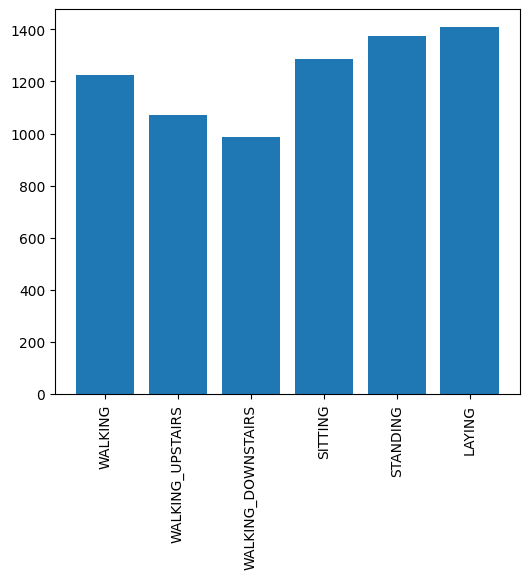

In [91]:
plt.figure(figsize = (6,5))
plt.bar(LABELS, np.unique(y_train, return_counts=True)[1])
plt.xticks(rotation=90);

> c) Estandarice los atributos con media 0 y variaza 1.

In [101]:
scaler = StandardScaler()

# Apply the scaler to transform the training data
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

## 2.2 Modelos de clasificación

### 2.2.1 Redes Neuronales

> a) ¿Cómo se entrena una red neuronal feedforward?

***RESPUESTA***

---
---
---

> b) ¿Qué es una neurona en este contexto?

Una neurona en el contexto de las redes neuronales es una unidad de procesamiento básica que realiza operaciones matemáticas en los datos de entrada para generar una salida utilizando pesos, un sesgo y una función de activación.

> c) ¿Qué es una función de activación y para que sirven?

Es una función aplicada a la salida de una neurona en una red neuronal, las más comunes son: lineal, sigmoid, ReLU, softmax, etc. Sirven para introducir no linealidad en la red y permiten modelar relaciones más complejas en los datos. Ayudan a determinar la salida de una neurona, facilitan el aprendizaje y la capacidad de generalización de la red neuronal.

> d) ¿A qué se le llama capa densa?

Es un tipo de capa en la que cada neurona está conectada a todas las neuronas de la capa anterior.

> e) Si usted conoce la dimensión entrada, la de salida, la cantidad de capas y neuronas de cada capa, ¿cómo se calcula la cantidad de pesos de la red?

La cantidad de pesos es igual a la cantidad de conexiones entre capas (agregando como nodo al _bias_), si consideramos que las capas son densas, la cantidad de conexiones entre dos capas es igual al producto de la cantidad de nodos de cada una, generalizando la idea tenemos que el total de pesos vienen dados por:

$$\# pesos = (N_e + 1)N_1 + \sum_{i  = 1}^{CO - 1} (N_i+1)N_{i+1} + (N_{CO}+1)N_s, \quad \text{si}~~ CO \geq 1$$
$$\# pesos = (N_e + 1)N_s,\quad \text{si}~~ CO = 0$$
Donde $N_i$ es la cantidad de neuronas de la $i$-ésima capa oculta, $N_e$ es la dimensión de entrada, $N_s$ la dimensión de salida y $CO$ la cantidad de capas ocultas. (Obs: Sumamos uno en el primer término de los productos, pues consideramos los _bias_)

> f) ¿A qué se refiere el fenómeno de gradiente desvaneciente?, ¿y el gradiente explosivo?

***RESPUESTA***

---
---
---

> g) Para esta tarea, como debería ser la capa de salida de la red considerando que previamente aplicó una transformación One Hot Encoding a las clases del conjunto?

Debería ser una capa de 6 neuronas, cada una con la probabilidad de pertenecer a la clase, como el modelo es multiclase lo recomendado es usar _softmax_ como función de activación en la capa de salida.

> h) Considere que la capa de entrada se llama "input_layer",  a la capa de salida le llamaremos "output_layer" y a las capas intermedias "hidden_layer(_units_, _activation_)" donde los parametros significan el numero de neuronas que tiene esa capa densa (Dense en Keras) y su activación. Cree las siguientes redes neuronales:

* input_layer -> output_layer

* input_layer -> hidden_layer(32, tanh) -> output_layer

* input_layer -> hidden_layer(32, sigmoid) -> output_layer

* input_layer -> hidden_layer(32, relu) -> output_layer

In [201]:
numero_de_entradas = x_train.shape[1]
numero_de_salidas = 6

modelos = [
    Sequential([Input(shape = (numero_de_entradas)),
                Dense(units=numero_de_salidas, activation='softmax')],
               name = 'Sin_capa_oculta'),
    Sequential([Input(shape = (numero_de_entradas)),
                Dense(units=32, activation='tanh'),
                Dense(units=numero_de_salidas, activation='softmax')],
               name = 'Modelo_tanh'),
    Sequential([Input(shape = (numero_de_entradas)),
                Dense(units=32, activation='sigmoid'),
                Dense(units=numero_de_salidas, activation='softmax')],
               name = 'Modelo_sigmoid'),
    Sequential([Input(shape = (numero_de_entradas)),
                Dense(units=32, activation='relu'),
                Dense(units=numero_de_salidas, activation='softmax')],
               name = 'Modelo_relu')
]

> i) Una vez creado el modelo, imprima el sumario (modelo.summary()) y compare los resultados obtenidos con su razonamiento explicado en la pregunta e).

In [202]:
for modelo in modelos:
  modelo.summary()
  print("\n")

Model: "Sin_capa_oculta"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_73 (Dense)            (None, 6)                 6918      
                                                                 
Total params: 6,918
Trainable params: 6,918
Non-trainable params: 0
_________________________________________________________________


Model: "Modelo_tanh"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_74 (Dense)            (None, 32)                36896     
                                                                 
 dense_75 (Dense)            (None, 6)                 198       
                                                                 
Total params: 37,094
Trainable params: 37,094
Non-trainable params: 0
_________________________________________________________________


Model: "Modelo_sigmo

Calculemos la cantidad de pesos según la fórmula entregada en e).

In [203]:
N_e = x_train.shape[1] #dimension entrada
N_s = 6 #dimension salida

def cant_pesos(N_e, N_s, CO=0, Nodos_capas_ocultas=[]):
  # Cantidad de pesos con capas ocultas densas
  if CO == 0:
    return (N_e+1)*N_s
  pesos_c = (N_e+1) * N[0]
  for i in range(CO-1):
    pesos_c += (N[i] + 1 ) * N[i+1]
  pesos_c += (N[-1] + 1) * N_s
  return pesos_c

pesos_sin = cant_pesos(N_e,N_s)
pesos_con = cant_pesos(N_e,N_s,1,[32])

print(f'Cantidad de pesos:\n\tModelo sin capa oculta: {pesos_sin:,}\n\tModelo con una capa oculta: {pesos_con:,}')

Cantidad de pesos:
	Modelo sin capa oculta: 6,918
	Modelo con una capa oculta: 37,094


Note que obtuvimos la misma cantidad de pesos.

 > j) Defina un callback de Early Stopping para evitar un sobre ajuste de la red basandose en sus respuestas a las siguientes preguntas:

* ¿Qué es lo que se debería monitorear para evitar el sobre ajuste en esta red?

Para evitar el sobreajuste en esta red, se debería monitorear el rendimiento del modelo en un conjunto de datos de validación durante el entrenamiento. El objetivo es detectar cuándo el rendimiento en el conjunto de validación comienza a empeorar o deja de mejorar significativamente, lo que indica que el modelo está sobreajustando los datos de entrenamiento.

* ¿Qué es la paciencia en este contexto?

La paciencia en este contexto se refiere al número de epochs que se permite que el rendimiento en el conjunto de validación empeore o se estanque antes de detener el entrenamiento. Si el rendimiento en el conjunto de validación no mejora después de un número determinado de epochs definido por la paciencia, se detiene el entrenamiento para evitar un sobreajuste adicional.

* ¿Para qué se usa el parámetro min_delta?

El parámetro min_delta se usa para definir la mínima mejora requerida en el rendimiento en el conjunto de validación para considerar que hay una mejora significativa. Si la mejora en el rendimiento es menor que el valor de min_delta, no se considera una mejora real y puede detenerse el entrenamiento incluso si la paciencia no se ha agotado.

In [208]:
early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           mode='max',
                           verbose=0,
                           patience=50
                           )

> k) Compile el modelo usando como optimizador el gradiente descendente estocástico, utilice la métrica "categorical_accuracy" y responda lo siguiente:

* ¿Qúe función de pérdida se debe usar para este problema (loss)?

Para este problema, que implica la clasificación de múltiples clases, se debe utilizar la función de pérdida "categorical_crossentropy". Esta función de pérdida es comúnmente utilizada en problemas de clasificación multiclase y es adecuada para modelos que generan salidas en forma de distribuciones de probabilidad para cada clase.

**Nota:** Si bien en un mundo ideal donde hay tiempo y recursos para explorar un subconjunto del espacio de hipótesis lo suficientemente amplio como para cubrir todas las posibles combinaciones de hiperparámetros, en esta tarea solo se explorarán algunos.

In [209]:
# Compilamos los modelos
for modelo in modelos:
    modelo.compile(optimizer='sgd',
                   loss='categorical_crossentropy',
                   metrics=['categorical_accuracy']
                   )

> l) Entrene el modelo utilizando el callback definido en la pregunta anterior con 100 epochs, un batch_size=256, y validation split=0.1.

* ¿Qué significa el batch_size?

Es la cantidad de muestras de entrenamiento que se utilizan en cada paso de actualización de los pesos del modelo.

**Nota:** Por favor recuerde ocultar el output del entrenamiento!! Mantenga el orden de su tarea y justifique de forma óptima sus resultados.

In [210]:
for modelo in modelos:
  modelo.fit(x_train, y_train_OHE,
             epochs=100,
             batch_size=256,
             validation_split = 0.1,
             callbacks=[early_stop],
             verbose = 0
             )

> m) Escoja el mejor modelo según la función de activación y puntuación obtenida en el conjunto de validación y pruebe con los siguientes modelos:

* input_layer -> hidden_layer(64, best_activ) -> hidden_layer(32, best_activ) -> output_layer

* input_layer -> hidden_layer(128, best_activ) -> hidden_layer(64, best_activ) -> hidden_layer(32, best_activ) -> output_layer

* input_layer -> hidden_layer(256, best_activ) -> hidden_layer(128, best_activ) -> hidden_layer(64, best_activ) -> hidden_layer(32, best_activ) -> output_layer

Escojamos el mejor modelo según la métrica utilizada:

In [222]:
modelos[1].evaluate(x_test, y_test_OHE, verbose = 1)

93/93 [==============================] - 0s 3ms/step - loss: 0.5385 - categorical_accuracy: 0.8388


[0.5385098457336426, 0.838819146156311]

In [217]:
for modelo in modelos:
    loss, accuracy = modelo.evaluate(x_test, y_test_OHE, verbose = 0)
    print(f"Modelo = {modelo.name}, {accuracy=:.3f}\n")

Modelo = Sin_capa_oculta, accuracy=0.566

Modelo = Modelo_tanh, accuracy=0.839

Modelo = Modelo_sigmoid, accuracy=0.811

Modelo = Modelo_relu, accuracy=0.874



En base al resultado anterior, tenemos que la mejor función de activación es la 'ReLU'. Creemos las redes usando esta función de activación:

In [219]:
numero_de_entradas = x_train.shape[1]
numero_de_salidas = 6

NNs = [
    Sequential([Input(shape = (numero_de_entradas)),
                Dense(units=64, activation='relu'),
                Dense(units=32, activation='relu'),
                Dense(units=numero_de_salidas, activation='softmax')],
               name = 'NN_1'),
    Sequential([Input(shape = (numero_de_entradas)),
                Dense(units=128, activation='relu'),
                Dense(units=64, activation='relu'),
                Dense(units=32, activation='relu'),
                Dense(units=numero_de_salidas, activation='softmax')],
               name = 'NN_2'),
    Sequential([Input(shape = (numero_de_entradas)),
                Dense(units=256, activation='relu'),
                Dense(units=128, activation='relu'),
                Dense(units=64, activation='relu'),
                Dense(units=32, activation='relu'),
                Dense(units=numero_de_salidas, activation='softmax')],
               name = 'NN_3')
]

>n) Imprima las curvas de error y accuracy del conjunto de entrenamiento y de validación para observar como se comporta el _aprendizaje_ de sus modelos.

In [226]:
for NN in NNs:
  NN.compile(optimizer='sgd',
             loss='categorical_crossentropy',
             metrics = ['accuracy']
             )
  history = NN.fit(x_train, y_train_OHE,
                   epochs=100,
                   batch_size=256,
                   validation_split = 0.1,
                   #callbacks=[early_stop],
                   verbose = 0
                   )
  NN.evaluate(x_test, y_test_OHE,verbose=1)
  break


93/93 [==============================] - 0s 2ms/step - loss: 0.3820 - accuracy: 0.8863


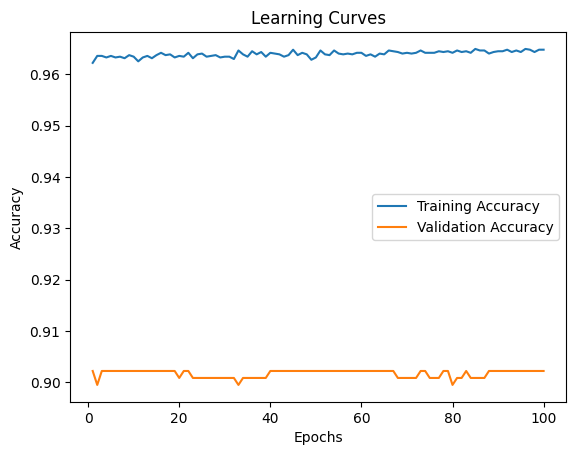

In [227]:
# Access the training and validation errors from the history object
train_errors = history.history['accuracy']
val_errors = history.history['val_accuracy']

# Get the number of epochs
epochs = range(1, len(train_errors) + 1)

# Plotting the learning curves
plt.plot(epochs, train_errors, label='Training Accuracy')
plt.plot(epochs, val_errors, label='Validation Accuracy')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Learning Curves')
plt.legend()

# Displaying the plot
plt.show()

> o) Una vez terminados los entrenamientos elija la mejor red hasta ahora y entrénela con el conjunto de entrenamiento completo sin validation split.

In [ ]:
"""
Su código aquí
"""

> p) Procese las predicciones del modelo sobre el conjunto de test para que pueda comparar los errores usando un heatmap de la matriz de confusión.

In [ ]:
y_pred = ANN(x_test)
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
y_test_comp = np.argmax(y_test_OHE, axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix

cat = np.array([1,2,3,4,5,6])

# Create the confusion matrix
cm = confusion_matrix(cat[y_test_comp], cat[y_pred])

# Get the number of classes
num_classes = 6

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add x-axis and y-axis labels
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, LABELS, rotation=75)
plt.yticks(tick_marks, LABELS)

# Add labels to each cell
thresh = cm.max() / 2.0
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

# Add axis labels
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Show the plot
plt.tight_layout()
plt.show()


> q) Comente acerca de los resultados y explique cual es la actividad que mejor logra clasificar la red.

### 2.2.2 AdaBoost y arbustos

> a) Describa brevemente como funciona el modelo AdaBoost.

> b) ¿Qué clasificador se puede usar junto con Adaboost?

> c) ¿Cómo funciona el _learning rate_ en el modelo AdaBoost?

> d) Separe el conjunto de entrenamiento dejando el 10% para validación.

> e) Entrene un clasificador AdaBoost con un arbusto (árbol de profundidad=2) con 300 estimadores y learning_rate=1

**Nota:** Este modelo no usa One Hot Encoder para las clases, investigue como preprocesar los datos del conjunto para entrenar este modelo. Puede guiarse con el siguiente tutorial de sklearn: https://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_multiclass.html#sphx-glr-auto-examples-ensemble-plot-adaboost-multiclass-py



In [ ]:
ada = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2), n_estimators=300, learning_rate=1
)

In [ ]:
ada.fit(x_train, y_train)

> f) Revise el error de validación con el conjunto de validaión.

In [ ]:
ada_errors = []

for ada_val_predict in ada.staged_predict(x_val):
    ada_val_errors.append(1.0 - accuracy_score(ada_val_predict, y_val))

n_trees_ada = len(ada)

> g) Haga la misma prueba pero ahora con 30 estimadores

In [ ]:
...

> h) Una vez encontrado el mejor modelo basandose en el error de validación, entrene el mejr modelo con todo el conjunto de entrenamiento, es decir, sin hacer _validation split_ y luego evalúe el modelo sobre el conjunto de pruebas.

> i) Muestre la matriz de confusión y comente sus resultados.

## 2.3 Conclusiones

Comente con qué modelo obtiene los mejores resultados, ¿qué otros experimentos realizaría para intentar mejorar los resultados?

